## Imports and constants

to do: 

transformers, features generation,
fix left bisect as described in the changed rules

In [1]:
SPLIT_SEED = 42
KFOLD_SPLITS = 3

IS_EMBEDDING_USED = True
if IS_EMBEDDING_USED:
    IS_GPU_USED = False
    FAISS_ITERATIONS = 10
    FACTORS = 10
    
IS_POLARS_USED = True
    
IS_NOTEBOOK_ON_KAGGLE = True
IS_NOTBOOK_ON_COLAB = False

IS_MODEL_TRANSFORMERS4REC = False
IS_MODEL_CATBOOST = True
IS_MODEL_RANDFOREST = False

In [2]:
!pip install feather-format >> none -q
!pip install polars -q

import bisect
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import plotly.express as px
import polars as pl
import pyarrow as pa
import pyarrow.parquet as pq
import seaborn as sns
import sklearn.metrics as m
import sys
import tensorflow as tf
import time
import warnings

from pathlib import Path
from sklearn.model_selection import KFold

if IS_EMBEDDING_USED:
    !pip install faiss-cpu --no-cache -q
    
    import implicit
    import scipy

if IS_MODEL_RANDFOREST:
    from sklearn.ensemble import RandomForestClassifier

if IS_MODEL_CATBOOST:
    from catboost import CatBoostClassifier, CatBoostRegressor, Pool

%matplotlib inline
sns.set_style('darkgrid')
warnings.filterwarnings('ignore')

In [3]:
if IS_NOTEBOOK_ON_KAGGLE:
    LOCAL_DATA_PATH = Path('/kaggle', 'input', 'mts-ml-cookies')
    DATA_FILE = Path('dataset_full.feather')
    TARGET_FILE = Path('target_train.feather')
    SUBMISSION_FILE = Path('submission.feather')

## Showing data

In [4]:
id_to_submit = pd.read_feather(Path(LOCAL_DATA_PATH, SUBMISSION_FILE))
display(id_to_submit.head(3))
display(id_to_submit.info)
id_to_submit.dropna(inplace=True)
display(id_to_submit.info)

,user_id
0,221301
1,31271
2,211594


<bound method DataFrame.info of         user_id
0        221301
1         31271
2        211594
3        253119
4        192578
...         ...
144719   415284
144720   415285
144721   415286
144722   415306
144723   415315

[144724 rows x 1 columns]>

<bound method DataFrame.info of         user_id
0        221301
1         31271
2        211594
3        253119
4        192578
...         ...
144719   415284
144720   415285
144721   415286
144722   415306
144723   415315

[144724 rows x 1 columns]>

In [5]:
targets = pd.read_feather(Path(LOCAL_DATA_PATH, TARGET_FILE)).query('age >=19') 
display(targets.head())
display(targets.info)
targets.dropna(inplace=True)
display(targets.info)

targets = pa.Table.from_pandas(targets)
display(pd.DataFrame([(z.name, z.type) for z in targets.schema], columns = [['field', 'type']]))

,age,is_male,user_id
0,31.0,1,350459
1,35.0,1,188276
2,41.0,0,99002
3,33.0,0,155506
4,54.0,0,213873


<bound method DataFrame.info of          age is_male  user_id
0       31.0       1   350459
1       35.0       1   188276
2       41.0       0    99002
3       33.0       0   155506
4       54.0       0   213873
...      ...     ...      ...
269995  49.0       1   225374
269996  22.0       1    25776
269997  28.0       0   148131
269998  28.0       1   205570
269999  68.0       1   103148

[268922 rows x 3 columns]>

<bound method DataFrame.info of          age is_male  user_id
0       31.0       1   350459
1       35.0       1   188276
2       41.0       0    99002
3       33.0       0   155506
4       54.0       0   213873
...      ...     ...      ...
269995  49.0       1   225374
269996  22.0       1    25776
269997  28.0       0   148131
269998  28.0       1   205570
269999  68.0       1   103148

[263508 rows x 3 columns]>

,field,type
0,age,double
1,is_male,string
2,user_id,int64
3,__index_level_0__,int64


In [6]:
data = pd.read_feather(Path(LOCAL_DATA_PATH, DATA_FILE))
display(data.head())

display(data.info)
data.dropna(inplace=True)
display(data.info)

,region_name,city_name,cpe_manufacturer_name,cpe_model_name,url_host,cpe_type_cd,cpe_model_os_type,price,date,part_of_day,request_cnt,user_id
0,Краснодарский край,Краснодар,Apple,iPhone 7,ad.adriver.ru,smartphone,iOS,20368.0,2022-06-15,morning,1,45098
1,Краснодарский край,Краснодар,Apple,iPhone 7,apple.com,smartphone,iOS,20368.0,2022-06-19,morning,1,45098
2,Краснодарский край,Краснодар,Apple,iPhone 7,avatars.mds.yandex.net,smartphone,iOS,20368.0,2022-06-12,day,1,45098
3,Краснодарский край,Краснодар,Apple,iPhone 7,googleads.g.doubleclick.net,smartphone,iOS,20368.0,2022-05-16,day,1,45098
4,Краснодарский край,Краснодар,Apple,iPhone 7,googleads.g.doubleclick.net,smartphone,iOS,20368.0,2022-05-30,day,1,45098


<bound method DataFrame.info of                   region_name  city_name cpe_manufacturer_name  \
0          Краснодарский край  Краснодар                 Apple   
1          Краснодарский край  Краснодар                 Apple   
2          Краснодарский край  Краснодар                 Apple   
3          Краснодарский край  Краснодар                 Apple   
4          Краснодарский край  Краснодар                 Apple   
...                       ...        ...                   ...   
322899430   Калужская область    Обнинск               Samsung   
322899431   Калужская область    Обнинск               Samsung   
322899432   Калужская область    Обнинск               Samsung   
322899433   Калужская область    Обнинск               Samsung   
322899434   Калужская область    Обнинск               Samsung   

             cpe_model_name                     url_host cpe_type_cd  \
0                  iPhone 7                ad.adriver.ru  smartphone   
1                  iPhone 7    

<bound method DataFrame.info of                   region_name  city_name cpe_manufacturer_name  \
0          Краснодарский край  Краснодар                 Apple   
1          Краснодарский край  Краснодар                 Apple   
2          Краснодарский край  Краснодар                 Apple   
3          Краснодарский край  Краснодар                 Apple   
4          Краснодарский край  Краснодар                 Apple   
...                       ...        ...                   ...   
322899430   Калужская область    Обнинск               Samsung   
322899431   Калужская область    Обнинск               Samsung   
322899432   Калужская область    Обнинск               Samsung   
322899433   Калужская область    Обнинск               Samsung   
322899434   Калужская область    Обнинск               Samsung   

             cpe_model_name                     url_host cpe_type_cd  \
0                  iPhone 7                ad.adriver.ru  smartphone   
1                  iPhone 7    

In [7]:
'''
for column in data.columns:
    sns.histplot(data[column].value_counts(), bins=4)
    plt.show()
'''

'\nfor column in data.columns:\n    sns.histplot(data[column].value_counts(), bins=4)\n    plt.show()\n'

In [8]:
for column in data.columns:
    if column not in ("date", "price", "user_id", "request_cnt"):
        data[column] = data[column].cat.codes
    elif column == "date":
        data["date"] = pd.to_datetime(data["date"])

data.head()

,region_name,city_name,cpe_manufacturer_name,cpe_model_name,url_host,cpe_type_cd,cpe_model_os_type,price,date,part_of_day,request_cnt,user_id
0,21,409,1,589,5788,2,2,20368.0,2022-06-15,2,1,45098
1,21,409,1,589,12900,2,2,20368.0,2022-06-19,2,1,45098
2,21,409,1,589,17626,2,2,20368.0,2022-06-12,0,1,45098
3,21,409,1,589,59366,2,2,20368.0,2022-05-16,0,1,45098
4,21,409,1,589,59366,2,2,20368.0,2022-05-30,0,1,45098


In [9]:
data = pl.from_pandas(data)
display(data.select(['cpe_type_cd']).to_pandas()['cpe_type_cd'].value_counts())
data['cpe_type_cd'].value_counts()

2    316272363
1        36078
3         1512
Name: cpe_type_cd, dtype: int64

cpe_type_cd,counts
i8,u32
3,1512
2,316272363
1,36078


## Counting users <-> items embedding

In [10]:
%%time
if IS_EMBEDDING_USED:
    data_agg = data.groupby(['user_id', 'url_host'], maintain_order=True).agg(
        pl.sum("request_cnt")
    )
    url_set = set(data_agg.select(['url_host']).to_pandas()['url_host'])
    print(f'{len(url_set)} urls')
    url_dict = {url: idurl for url, idurl in zip(url_set, range(len(url_set)))}
    usr_set = set(data_agg.select(['user_id']).to_pandas()['user_id'])
    print(f'{len(usr_set)} users')
    usr_dict = {usr: user_id for usr, user_id in zip(usr_set, range(len(usr_set)))}

198032 urls
404614 users
CPU times: user 1min 41s, sys: 26.1 s, total: 2min 7s
Wall time: 57.3 s


In [11]:
%%time
if IS_EMBEDDING_USED:
    values = np.array(data_agg['request_cnt'].to_pandas())
    rows = np.array(data_agg['user_id'].to_pandas().map(usr_dict))
    cols = np.array(data_agg['url_host'].to_pandas().map(url_dict))
    mat = scipy.sparse.coo_matrix((values, (rows, cols)), shape=(rows.max() + 1, cols.max() + 1))
    als = implicit.approximate_als.FaissAlternatingLeastSquares(
        factors = FACTORS, iterations = FAISS_ITERATIONS, use_gpu = IS_GPU_USED, calculate_training_loss = True, regularization = 0.1
    )

CPU times: user 2.17 s, sys: 793 ms, total: 2.96 s
Wall time: 2.95 s


In [12]:
%%time
if IS_EMBEDDING_USED:
    als.fit(mat)

  0%|          | 0/10 [00:00<?, ?it/s]

CPU times: user 10min 55s, sys: 5min 58s, total: 16min 54s
Wall time: 4min 19s


In [13]:
if IS_EMBEDDING_USED:
    u_factors = als.user_factors 
    print(len(u_factors))

198032


In [14]:
if IS_EMBEDDING_USED:
    d_factors = als.item_factors
    print(len(d_factors))

404614


## Sex prediction

In [15]:
if IS_EMBEDDING_USED:
    inv_usr_map = {v: k for k, v in usr_dict.items()}
    usr_emb = pd.DataFrame(d_factors)
    usr_emb['user_id'] = usr_emb.index.map(inv_usr_map)
    
    usr_targets = targets.to_pandas()
    df = usr_targets.merge(usr_emb, how = 'inner', on = ['user_id'])
    
    df['cpe_model_name'] = data['cpe_model_name'].to_pandas()
    
    display(df.info)
    df = df[df['is_male'] != 'NA']
    df = df.dropna()
    display(df.info)
    
    df['is_male'] = df['is_male'].map(int)
    print(df['is_male'].value_counts())
    display(df.head())

<bound method DataFrame.info of          age is_male  user_id         0         1         2         3  \
0       31.0       1   350459 -0.041562 -0.011178 -0.011656  0.087850   
1       35.0       1   188276  0.034047 -0.050921  0.046756  0.114737   
2       41.0       0    99002  0.008907 -0.036523 -0.009585 -0.029234   
3       33.0       0   155506 -0.014308 -0.044123  0.038922  0.067348   
4       54.0       0   213873 -0.000697 -0.008681  0.007356  0.013507   
...      ...     ...      ...       ...       ...       ...       ...   
256749  50.0       1   176446  0.021124  0.002352  0.052535 -0.037946   
256750  49.0       1   225374  0.137898 -0.012216  0.061525  0.004392   
256751  28.0       0   148131 -0.034276 -0.047130  0.038980  0.072313   
256752  28.0       1   205570 -0.054794 -0.011331 -0.022709  0.046418   
256753  68.0       1   103148  0.016775 -0.046898 -0.031462  0.059889   

               4         5         6         7         8         9  \
0       0.059249 -0.0

<bound method DataFrame.info of          age is_male  user_id         0         1         2         3  \
0       31.0       1   350459 -0.041562 -0.011178 -0.011656  0.087850   
1       35.0       1   188276  0.034047 -0.050921  0.046756  0.114737   
2       41.0       0    99002  0.008907 -0.036523 -0.009585 -0.029234   
3       33.0       0   155506 -0.014308 -0.044123  0.038922  0.067348   
4       54.0       0   213873 -0.000697 -0.008681  0.007356  0.013507   
...      ...     ...      ...       ...       ...       ...       ...   
256749  50.0       1   176446  0.021124  0.002352  0.052535 -0.037946   
256750  49.0       1   225374  0.137898 -0.012216  0.061525  0.004392   
256751  28.0       0   148131 -0.034276 -0.047130  0.038980  0.072313   
256752  28.0       1   205570 -0.054794 -0.011331 -0.022709  0.046418   
256753  68.0       1   103148  0.016775 -0.046898 -0.031462  0.059889   

               4         5         6         7         8         9  \
0       0.059249 -0.0

1    130899
0    125855
Name: is_male, dtype: int64


,age,is_male,user_id,0,1,2,3,4,5,6,7,8,9,cpe_model_name
0,31.0,1,350459,-0.041562,-0.011178,-0.011656,0.087850,0.059249,-0.010939,0.015674,-0.001987,-0.024404,-0.012899,589
1,35.0,1,188276,0.034047,-0.050921,0.046756,0.114737,0.069693,-0.051150,0.004264,-0.042289,-0.038273,-0.044078,589
2,41.0,0,99002,0.008907,-0.036523,-0.009585,-0.029234,0.040251,0.007527,0.001558,0.015669,0.038165,0.014630,589
3,33.0,0,155506,-0.014308,-0.044123,0.038922,0.067348,0.074553,-0.013014,-0.003994,0.012429,-0.060842,-0.017467,589
4,54.0,0,213873,-0.000697,-0.008681,0.007356,0.013507,0.013946,-0.003085,-0.001396,0.001843,-0.011137,-0.004560,589


In [16]:
df_submit = id_to_submit.merge(usr_emb, how = 'left', on = ['user_id']).drop(['user_id'], axis = 1)
#id_to_submit[['user_id']].merge(usr_emb, how = 'left', on = ['user_id']).drop(['user_id'], axis = 1)
df_submit['cpe_model_name'] = data['cpe_model_name'].to_pandas()

#### Model trainings

In [17]:
max_gini = 0
train_index = 0
test_index = 0

if IS_MODEL_CATBOOST:
    clf = CatBoostClassifier()
elif IS_MODEL_RANDFOREST:
    clf = RandomForestClassifier(random_state=SPLIT_SEED)

In [18]:
%%time
if IS_MODEL_CATBOOST or IS_MODEL_RANDFOREST:
    x = df.drop(['user_id', 'age', 'is_male'], axis = 1)
    y = df['is_male']
    cat_features = ['cpe_model_name']

    kf = KFold(n_splits=KFOLD_SPLITS)

    for train_index, test_index in kf.split(x):
        print("Train indexes: ", train_index[:5],
              "; Test indexes: ", test_index[:5], ";\n",
              "Train length: ", len(train_index), 
              "; Test length: ", len(test_index), 
              "; Dataset length: ", len(x), ';', sep='', end='\n')
        
        x_train, x_test = x.iloc[train_index], x.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        
        if IS_MODEL_CATBOOST:
            clf.fit(x_train, y_train, cat_features, verbose = False)
        elif IS_MODEL_RANDFOREST:
            clf.fit(x_train, y_train)
        
        gini = float(f'{2 * m.roc_auc_score(y_test, clf.predict_proba(x_test)[:,1]) - 1:2.3f}')
        if gini > max_gini:
            max_gini = gini
            max_train_index = train_index
            max_test_index = test_index
        
        print(f'Current GINI is {gini}, current max is {max_gini}', end="\n\n")

Train indexes: [85585 85586 85587 85588 85589]; Test indexes: [0 1 2 3 4];
Train length: 171169; Test length: 85585; Dataset length: 256754;
Current GINI is 0.395, current max is 0.395

Train indexes: [0 1 2 3 4]; Test indexes: [85585 85586 85587 85588 85589];
Train length: 171169; Test length: 85585; Dataset length: 256754;
Current GINI is 0.393, current max is 0.395

Train indexes: [0 1 2 3 4]; Test indexes: [171170 171171 171172 171173 171174];
Train length: 171170; Test length: 85584; Dataset length: 256754;
Current GINI is 0.396, current max is 0.396

CPU times: user 16min 33s, sys: 36.1 s, total: 17min 9s
Wall time: 4min 42s


In [19]:
print(f'Max GINI is {max_gini}')
print(f'Max train index is {max_train_index[:2]}...{max_train_index[-2:]}')
print(f'Max test index is {max_test_index[:2]}...{max_test_index[-2:]}')

Max GINI is 0.396
Max train index is [0 1]...[171168 171169]
Max test index is [171170 171171]...[256752 256753]


In [20]:
if IS_MODEL_CATBOOST or IS_MODEL_RANDFOREST:
    if IS_MODEL_CATBOOST:
        clf.fit(x.iloc[max_train_index], y.iloc[max_train_index], cat_features, verbose = False)
    elif IS_MODEL_RANDFOREST:
        clf.fit(x.iloc[max_train_index], y.iloc[max_train_index])
    id_to_submit['user_id'].unique
    id_to_submit['is_male'] = clf.predict_proba(df_submit)[:,1]
    
id_to_submit.head()

,user_id,is_male
0,221301,0.738621
1,31271,0.511810
2,211594,0.529462
3,253119,0.481549
4,192578,0.631900


In [21]:
print("Current GINI score: ", float(f'{2 * m.roc_auc_score(y.iloc[max_test_index], clf.predict_proba(x.iloc[max_test_index])[:,1]) - 1:2.3f}'))

Current GINI score:  0.396


## Age prediction

In [22]:
def age_bucket(x):
    return bisect.bisect_left([18,25,35,45,55,65], x)

<AxesSubplot:xlabel='age', ylabel='Count'>

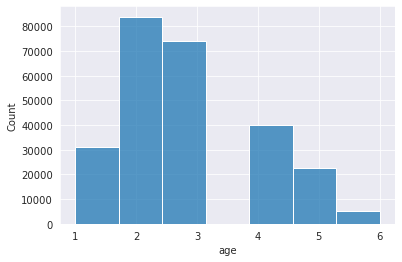

In [23]:
'''
df = usr_targets.merge(usr_emb, how = 'inner', on = ['user_id'])
df = df[df['age'] != 'NA']
df = df.dropna()
'''

df['age'] = df['age'].map(age_bucket)
sns.histplot(df['age'], bins = 7)

In [24]:
max_f1 = 0
train_index = 0
test_index = 0

if IS_MODEL_CATBOOST:
    clf = CatBoostClassifier()
elif IS_MODEL_RANDFOREST:
    clf = RandomForestClassifier(random_state=SPLIT_SEED)

In [25]:
if IS_MODEL_CATBOOST or IS_MODEL_RANDFOREST:
    x = df.drop(['user_id', 'age', 'is_male'], axis = 1)
    y = df['age']

    kf = KFold(n_splits=KFOLD_SPLITS)

    for train_index, test_index in kf.split(x):
        print("Train indexes: ", train_index[:5],
              "; Test indexes: ", test_index[:5], ";\n",
              "Train length: ", len(train_index), 
              "; Test length: ", len(test_index), 
              "; Dataset length: ", len(x), ';', sep='', end='\n')
        
        x_train, x_test = x.iloc[train_index], x.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        if IS_MODEL_CATBOOST:
            clf.fit(x_train, y_train, cat_features, verbose = False)
        elif IS_MODEL_RANDFOREST:
            clf.fit(x_train, y_train)
        
        f1 = m.f1_score(y_test, clf.predict(x_test), average='weighted')
        if f1 > max_f1:
            max_f1 = f1
            max_train_index = train_index
            max_test_index = test_index
        
        print(f'Current F1 is {f1}, current max is {max_f1}', end="\n\n")

Train indexes: [85585 85586 85587 85588 85589]; Test indexes: [0 1 2 3 4];
Train length: 171169; Test length: 85585; Dataset length: 256754;
Current F1 is 0.36191340241753645, current max is 0.36191340241753645

Train indexes: [0 1 2 3 4]; Test indexes: [85585 85586 85587 85588 85589];
Train length: 171169; Test length: 85585; Dataset length: 256754;
Current F1 is 0.358572774144682, current max is 0.36191340241753645

Train indexes: [0 1 2 3 4]; Test indexes: [171170 171171 171172 171173 171174];
Train length: 171170; Test length: 85584; Dataset length: 256754;
Current F1 is 0.3640686645190585, current max is 0.3640686645190585



In [26]:
print(f'Max F1 is {max_f1}')
print(f'Max train index is {max_train_index[:5]}')
print(f'Max test index is {max_test_index[:5]}')

Max F1 is 0.3640686645190585
Max train index is [0 1 2 3 4]
Max test index is [171170 171171 171172 171173 171174]


In [27]:
if IS_MODEL_CATBOOST or IS_MODEL_RANDFOREST:
    if IS_MODEL_CATBOOST:
        clf.fit(x.iloc[max_train_index], y.iloc[max_train_index], cat_features, verbose = False)
    elif IS_MODEL_RANDFOREST:
        clf.fit(x.iloc[max_train_index], y.iloc[max_train_index])
    id_to_submit['age'] = clf.predict(df_submit)
    
id_to_submit.head()

,user_id,is_male,age
0,221301,0.738621,2
1,31271,0.511810,3
2,211594,0.529462,2
3,253119,0.481549,3
4,192578,0.631900,2


In [28]:
if IS_MODEL_CATBOOST or IS_MODEL_RANDFOREST:
    print(m.classification_report(
          y.iloc[max_test_index], 
          clf.predict(x.iloc[max_test_index]), 
          target_names = ['18-25','25-34', '35-44', '45-54', '55-65', '65+']
    ))

              precision    recall  f1-score   support

       18-25       0.46      0.18      0.26     10348
       25-34       0.43      0.63      0.51     28046
       35-44       0.35      0.47      0.40     24621
       45-54       0.33      0.13      0.19     13362
       55-65       0.38      0.15      0.21      7493
         65+       0.27      0.01      0.02      1714

    accuracy                           0.40     85584
   macro avg       0.37      0.26      0.27     85584
weighted avg       0.39      0.40      0.36     85584



## Submission

In [29]:
id_to_submit.loc[id_to_submit['age'].isna(),'age'] = 1
id_to_submit.loc[id_to_submit['is_male'].isna(),'is_male'] = 0.511735
id_to_submit['age'] = id_to_submit['age'].astype(int)
id_to_submit.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 144724 entries, 0 to 144723
Data columns (total 3 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   user_id  144724 non-null  int32  
 1   is_male  144724 non-null  float64
 2   age      144724 non-null  int64  
dtypes: float64(1), int32(1), int64(1)
memory usage: 3.9 MB


In [30]:
display(id_to_submit.head())
display(id_to_submit.is_male.value_counts())
display(id_to_submit.age.value_counts())
id_to_submit.to_csv('submission.csv', index = False)

,user_id,is_male,age
0,221301,0.738621,2
1,31271,0.511810,3
2,211594,0.529462,2
3,253119,0.481549,3
4,192578,0.631900,2


0.883580    552
0.931829    501
0.937031    430
0.929369    408
0.930119    391
           ... 
0.211027      1
0.523355      1
0.589723      1
0.506389      1
0.516058      1
Name: is_male, Length: 138865, dtype: int64

2    67907
3    54617
4     9523
1     8256
5     4334
6       87
Name: age, dtype: int64

In [31]:
print(f'Score: {max_gini + 2*max_f1}')

Score: 1.124137329038117
